# Preparação dos Microdados do ENEM
Este notebook faz um processamento inicial dos microdados do ENEM e guarda dados processados no diretório `data`, que deve existir. É preciso:
* fazer [download dos microdados do INEP](https://www.gov.br/inep/pt-br/acesso-a-informacao/dados-abertos/microdados/enem) e colocar num diretório `../inep/enem/{ano}`.
* nos diretórios `../inep/enem/{ano}/DADOS/`, converter os dados dos itens `ITENS_XXX.csv` para utf8 (usando `iconv -f iso-8859-1 -t utf-8 ITENS_PROVA_2023.csv > ITENS_PROVA_2023-utf8.csv`, veja mais [receitas aqui](https://github.com/atp/enem/wiki).
 


In [1]:
import numpy as np
import pandas as pd
import random
import seaborn as sns

%load_ext autoreload
%autoreload 2

import warnings
#warnings.filterwarnings("ignore")

In [2]:
print("numpy: ",np.__version__)
print("pandas: ", pd.__version__)

numpy:  2.1.1
pandas:  2.2.2


# Ler microdados do ENEM

## Selecionar apenas uma amostra aleatória de 1% dos alunos
Se a gente lê o arquivo de 3GB inteiro, vai dar problema. Aqui tem uma receita para ler somente x%: https://www.kaggle.com/questions-and-answers/53925 

In [3]:
def skip(i,fraction=0.01):
    if i == 0:
        return False  # precisamos manter o row=0 para ter o header
    else:
        return random.random() > fraction

[skip(i) for i in range(10)]

[False, True, True, False, True, True, True, True, True, True]

A título de exemplo, vamos carregar os dados de 2010.

In [4]:
%time df = pd.read_csv('../inep/enem/2010/DADOS/MICRODADOS_ENEM_2010.csv',skiprows = skip, encoding='latin1',sep=";")

CPU times: user 19.6 s, sys: 2.42 s, total: 22 s
Wall time: 42.6 s


In [5]:
df.sample()

,NU_INSCRICAO,NU_ANO,TP_FAIXA_ETARIA,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_ST_CONCLUSAO,TP_ENSINO,CO_MUNICIPIO_ESC,NO_MUNICIPIO_ESC,...,Q48,Q49,Q50,Q51,Q52,Q53,Q54,Q55,Q56,Q57
586,200000057184,2010,5,F,0,3,1,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
len(df)

46355

De fato, só vem 50 mil linhas (os dados originais devem conter da ordem de 3-6 milhões de participantes)

Em seguinda, vamos filtrar estes dados pela presença na prova, se é treineiro e estar concluindo o EM.

In [7]:
df["TP_PRESENCA_CN"].value_counts(dropna=False)

TP_PRESENCA_CN
1    34049
0    12236
2       70
Name: count, dtype: int64

In [8]:
df['TP_ST_CONCLUSAO'].value_counts(dropna=False)

TP_ST_CONCLUSAO
1    27115
2    13786
3     5454
Name: count, dtype: int64

In [9]:
df["TP_ESTADO_CIVIL"].value_counts(dropna=False)

TP_ESTADO_CIVIL
0    37808
1     7503
2      907
3      137
Name: count, dtype: int64

## Filtrar os dados por presença, treineiro, EM e notas não-zero
A seguir, as funções de filtrar os microdados. Em particular, usamos TP_ST_CONCLUSAO = 1 ou 2 (3o ano do EM, ou já formado no EM). Análises posteriores podem estar interessados em somente os alunos do 3o ano do EM e terão que fazer um filtro posterior ainda. 

In [10]:
def filterdf(df):
    df = df[df["TP_PRESENCA_CN"] == 1]  # presente nas 4 provas
    df = df[df["TP_PRESENCA_CH"] == 1]
    df = df[df["TP_PRESENCA_LC"] == 1]
    df = df[df["TP_PRESENCA_MT"] == 1]
    if "IN_TREINEIRO" in df.columns:
        df = df[(df["IN_TREINEIRO"] == 0) | (df["IN_TREINEIRO"].isna())]  # não é treineiro ou não existe 
    df = df[df["TP_ST_CONCLUSAO"].isin([1, 2])]  # afirma que concluiu EM ou que vai concluir EM no ano da aplicação
    # não queremos as notas == 0
    df = df.query("NU_NOTA_CH != 0 and NU_NOTA_CN != 0 and NU_NOTA_LC != 0 and NU_NOTA_MT != 0")
    df.dropna(subset = ['TX_RESPOSTAS_CN','TX_RESPOSTAS_CH','TX_RESPOSTAS_LC','TX_RESPOSTAS_MT']) # achamos linhas com NaN para estas colunas!
    # achamos gabaritos com '---------------------------------------------'
    for area in ['CN','CH','LC','MT']:
        df = df[df['TX_GABARITO_'+area] !='---------------------------------------------']
    return df


def load_data(ano,frac,orig=False):
    'carrega dados com determinado ano e fração'
    print(f"processando {ano} com fraçao = {frac*100:.0f}%",ano, frac)
    def skip(i,fraction=frac):
        if i == 0:
            return False  # precisamos manter o row=0 para ter o header
        else:
            return random.random() > fraction
   
    if ano == 2016:
        caminho = f'../inep/enem/{ano}/DADOS/microdados_enem_{ano}.csv'
    else:
        caminho = f'../inep/enem/{ano}/DADOS/MICRODADOS_ENEM_{ano}.csv'
    if orig:
        caminho = f'../inep/enem/orig/{ano}/DADOS/MICRODADOS_ENEM_{ano}.csv'
        if ano == 2016:
            caminho = f'../inep/enem/orig/{ano}/DADOS/microdados_enem_{ano}.csv'
            
    print(caminho)
    df = pd.read_csv(caminho,skiprows = skip, encoding='latin1',sep=";")
    return df
    
def filter_data(df):
    print("filter data...")
    return filterdf(df)

def nome_do_arquivo(ano,frac,orig):
    frac = frac*100
    if orig:
      fn = f'data/enem_{frac:.0f}_{ano}_orig.csv'
    else:
        fn = f'data/enem_{frac:.0f}_{ano}.csv'
    return fn

df = load_data(2019,0.01,orig=True)
print(len(df))
df = filter_data(df)
print(len(df))

processando 2019 com fraçao = 1% 2019 0.01
../inep/enem/orig/2019/DADOS/MICRODADOS_ENEM_2019.csv
50673
filter data...
31374


Vemos que das 50 mil linhas na amostra de 1% original de 2019, sobraram 31 mil. 

## Aqui faremos o trabalho de verdade
Isso deve levar alguns minutos.

In [12]:
frac = 0.02 #amostra de 2%
orig = False # if True, use the original data before INEP implemented LGPD filters (only 2009-2019)
for ano in range(2009,2024):
    df = load_data(ano,frac,orig=orig)
    df = filter_data(df)
    fn = nome_do_arquivo(ano,frac,orig=orig)
    #print(fn+"...\n")
    df.to_csv(fn,index=False)

import inspect
filter_conditions = inspect.getsource(filterdf)
with open('data/filters.txt','w') as f:
    f.write(filter_conditions)

processando 2009 com fraçao = 2% 2009 0.02
../inep/enem/2009/DADOS/MICRODADOS_ENEM_2009.csv
filter data...
processando 2010 com fraçao = 2% 2010 0.02
../inep/enem/2010/DADOS/MICRODADOS_ENEM_2010.csv
filter data...
processando 2011 com fraçao = 2% 2011 0.02
../inep/enem/2011/DADOS/MICRODADOS_ENEM_2011.csv
filter data...
processando 2012 com fraçao = 2% 2012 0.02
../inep/enem/2012/DADOS/MICRODADOS_ENEM_2012.csv
filter data...
processando 2013 com fraçao = 2% 2013 0.02
../inep/enem/2013/DADOS/MICRODADOS_ENEM_2013.csv
filter data...
processando 2014 com fraçao = 2% 2014 0.02
../inep/enem/2014/DADOS/MICRODADOS_ENEM_2014.csv
filter data...
processando 2015 com fraçao = 2% 2015 0.02
../inep/enem/2015/DADOS/MICRODADOS_ENEM_2015.csv
filter data...
processando 2016 com fraçao = 2% 2016 0.02
../inep/enem/2016/DADOS/microdados_enem_2016.csv
filter data...
processando 2017 com fraçao = 2% 2017 0.02
../inep/enem/2017/DADOS/MICRODADOS_ENEM_2017.csv
filter data...
processando 2018 com fraçao = 2% 2018

### Demonstração
Para demonstrar o que podemos fazer com os arquivos gerados:

In [15]:
from util import load_sample
df = load_sample(2011,n=500,perc=2) # uma amostra de 500 linhas, por sua vez, da nossa amostra de 1%
df

,NU_INSCRICAO,NU_ANO,TP_FAIXA_ETARIA,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,...,Q066,Q067,Q068,Q069,Q070,Q071,Q072,Q073,Q074,Q075
61113,300004913667,2011,10,F,1,1,1,3,1,1.0,...,A,A,D,D,B,A,D,D,D,A
25102,300001842865,2011,6,M,1,1,1,0,1,1.0,...,D,A,A,D,A,A,D,D,D,A
59336,300004730569,2011,2,M,1,1,2,4,1,1.0,...,A,A,A,A,C,B,A,D,D,C
11596,300000833537,2011,3,M,1,1,2,8,1,1.0,...,A,A,A,A,B,A,D,D,D,A
22972,300001675100,2011,2,F,1,1,2,0,2,1.0,...,A,A,D,A,A,A,D,D,D,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60311,300004829071,2011,9,F,1,3,1,1,1,1.0,...,A,A,A,A,B,D,D,D,D,A
14868,300001071469,2011,3,M,1,3,2,2,1,1.0,...,D,A,D,D,A,D,D,D,D,A
35213,300002629162,2011,2,M,1,3,2,0,2,1.0,...,A,A,D,D,C,D,D,D,D,A
36663,300002745145,2011,7,F,1,3,2,0,1,1.0,...,D,A,D,D,D,D,D,D,D,D


<Axes: xlabel='NU_NOTA_CH', ylabel='Count'>

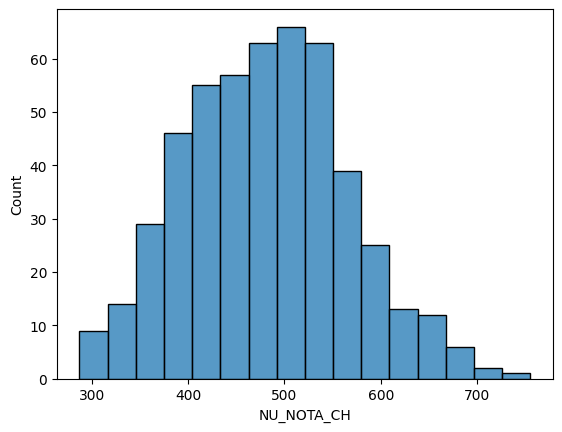

In [16]:
sns.histplot(df,x='NU_NOTA_CH')

In [18]:
l = []
for ano in range(2009,2024):
    l.append(load_sample(ano,1000))
df = pd.concat(l)

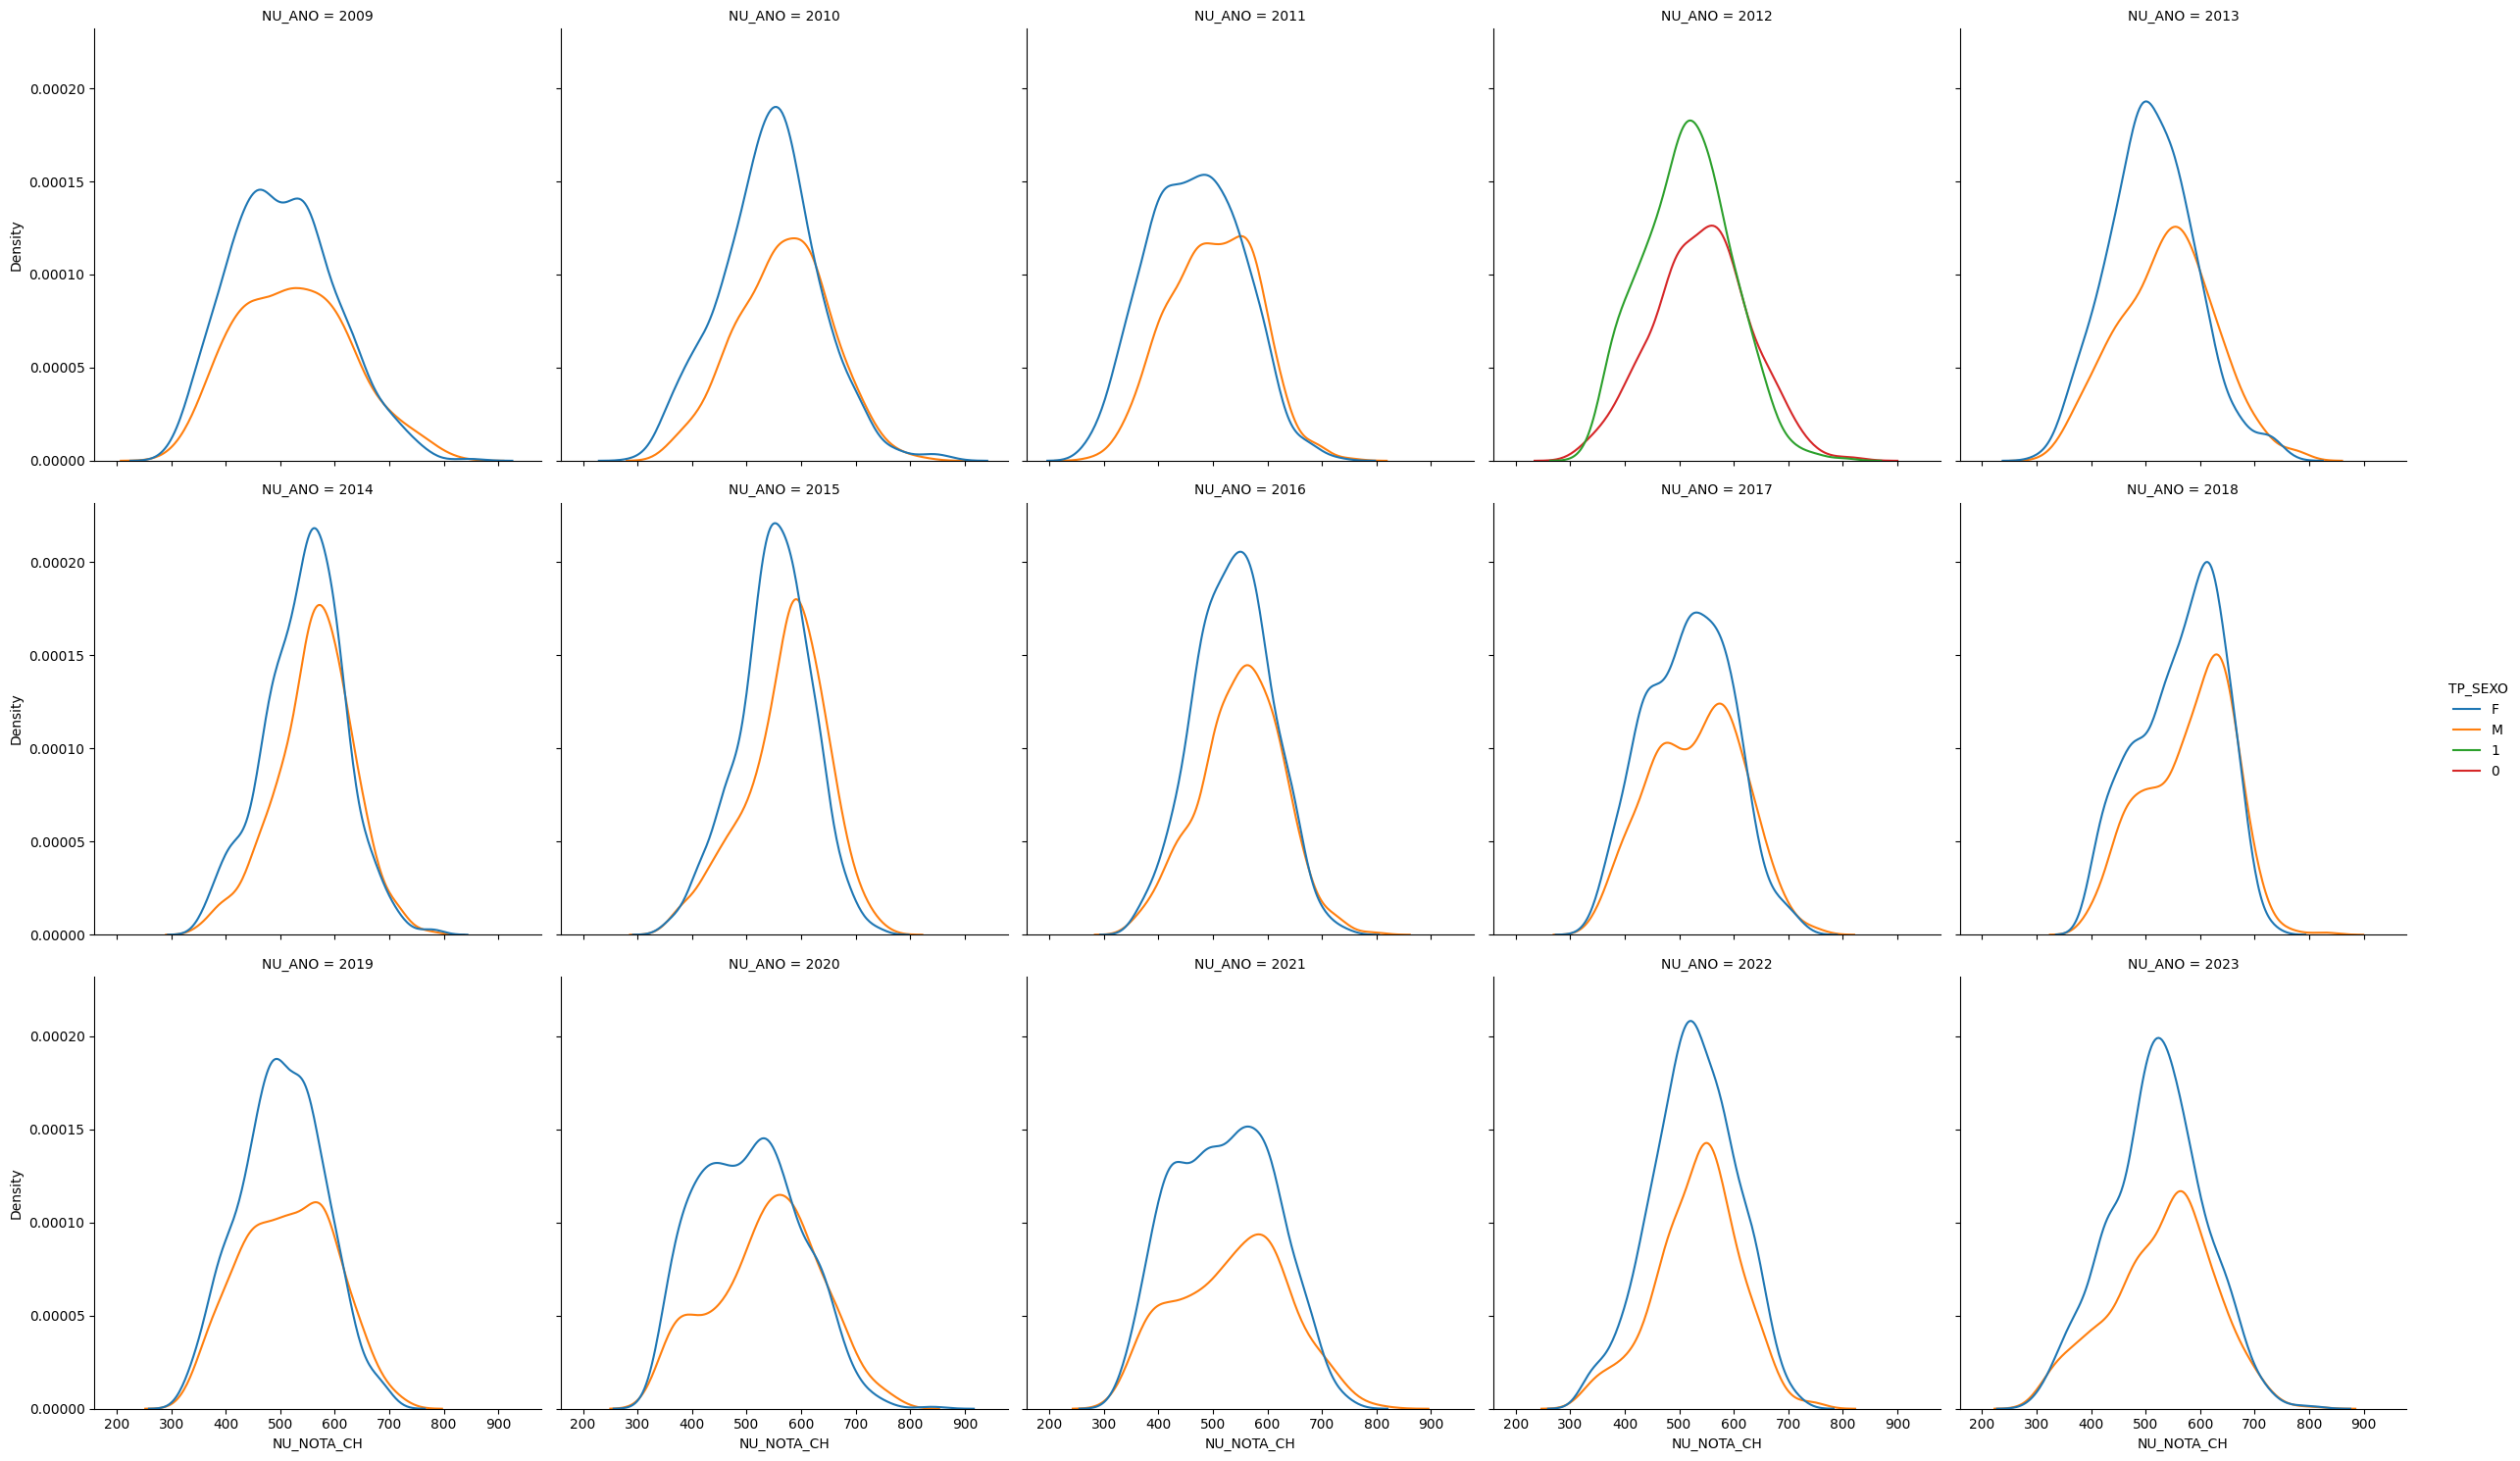

In [19]:
sns.displot(df,x='NU_NOTA_CH',kind='kde',hue='TP_SEXO',col='NU_ANO',col_wrap=5)

# Informação dos itens

Abaixo carregamos todas as planilhas com informações sobre os itens do ENEM disponibilizadas pelo INEP. Assumimos que as planilhas já foram convertidas para utf8. Em 2009 houve alguns itens sem CO_ITEM. Parece interessante de carregar estes dados sempre usando `dtype={'CO_ITEM':str}`, para que o pandas não interpreta o número como `float`. Vamos guardar estes informações sobre os itens fornecidos pelo INEP em `data/itens_inep.csv`

## Planilha com todos os dados do INEP
Por incrível que pareça, a cor AMARELO/A não é padronizado entre anos, nem a capitalização.



In [20]:
def padronizar_amarelo(s):
    if s == 'AMARELO':
        return 'AMARELA'
    else:
        return s

df = pd.DataFrame()
for ano in range(2009,2024):
    item_info = pd.read_csv(f'../dados/enem/{ano}/DADOS/ITENS_PROVA_{ano}-utf8.csv',sep='\;',
                        engine='python',dtype={'CO_ITEM':str})
    item_info['ano'] = ano
    item_info['TX_COR'] = item_info['TX_COR'].str.upper().str.strip()
    item_info['TX_COR'] = item_info['TX_COR'].apply(padronizar_amarelo)
    df = pd.concat([df,item_info])
    
df.to_csv('data/itens_inep.csv',index=False)

### Demonstração
Agora é simples usar as informções sobre os itens dado pelo INEP (vamos usar em particular os parâmetros TRI dos itens)

In [21]:
from util import item_info_inep
item_info_inep(2011,'CH')

,CO_POSICAO,SG_AREA,CO_ITEM,TX_GABARITO,CO_HABILIDADE,IN_ITEM_ABAN,TX_MOTIVO_ABAN,NU_PARAM_A,NU_PARAM_B,NU_PARAM_C,TX_COR,CO_PROVA,ano,TP_LINGUA,IN_ITEM_ADAPTADO,TP_VERSAO_DIGITAL
3032,2,CH,70264,E,22.0,0,NaN,1.60553,0.33263,0.09496,BRANCO,134,2011,NaN,NaN,NaN
3075,29,CH,70452,A,21.0,0,NaN,2.06152,0.49627,0.15444,BRANCO,134,2011,NaN,NaN,NaN
3080,20,CH,70475,C,13.0,0,NaN,0.94594,2.61392,0.19809,BRANCO,134,2011,NaN,NaN,NaN
3086,19,CH,70514,A,15.0,0,NaN,2.36969,-0.02116,0.09568,BRANCO,134,2011,NaN,NaN,NaN
3087,17,CH,70524,C,6.0,0,NaN,2.01158,1.72406,0.16014,BRANCO,134,2011,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3769,15,CH,75706,C,7.0,0,NaN,1.25147,-0.22962,0.22347,AZUL,117,2011,NaN,NaN,NaN
3771,10,CH,75717,A,26.0,0,NaN,1.97592,0.03668,0.24629,ROSA,120,2011,NaN,NaN,NaN
3772,11,CH,75717,A,26.0,0,NaN,1.97592,0.03668,0.24629,AMARELA,118,2011,NaN,NaN,NaN
3773,12,CH,75717,A,26.0,0,NaN,1.97592,0.03668,0.24629,AZUL,117,2011,NaN,NaN,NaN


# Preparar os dados para análise TRI
Precisamos converter as respostas e o gabarito no microdados do INEP para um formato que os pacotes de TRI conseguem ler.

## Funções para extrair acertos
A maioria das análises TRI vão precisar de uma "dicomitização" das respostas. A estrutura de dados que vamos precisar é uma matriz com colunas itens e linhas pessoas com valores 0 e 1 para erros e acertos respectivamente.

Vamos tentar criar umas funções que crie este estrutura de dados. Temos algumas informações sobre a estrutura dos microdados:
* Vamos ter que levar em conta as primeiras 5 itens da prova LC (Linguágens e Códigos). Desde 2010 estas posições são usadas para as questões de língua estrangeira (espanhol ou inglês). É possível, mas não tenho certeza, que somente 40 questões de LC são usados para criar a escala IRT desta prova.
* O INEP divulga os parámetros IRT (veja acima). Além disso, dizem quais itens foram eliminados ("pelo IRT"), porque aparentemente atrapalharam a convergência da estimação do modelo IRT 3PL que estão usando. Vamos identificar estes itens, para poder decidir na hora da análise se incluir ou não.

In [22]:
from util import load_sample, item_info_inep


In [23]:
# Um monte de gambiarra, mas o resultado final deve ser a conversão dos microdados originais, com colunas do tipo
# "ABBCABE..." para as respostas e gabaritos, para dataframes com colunas (com nomes do itens dados pelo INEP) e linhas
# do tipo 0,1,0,0,1... para acertos e erros.

# Um maior chatice é tratar LC, que tem um jeito particularmente inconveniente de guardar se o aluno fez 5 questões de inglês
# ou de espanhol no início da prova. 

def to_acertos(s):
    'resp e gab são strings, retorna uma lista'
    resp = s.iloc[0]
    gab = s.iloc[1]
    return [r == g for r,g in zip(resp,gab)]

def to_acertos_lc(s):
    'resp e gab são strings, retorna uma lista'
    lang = s.iloc[2]
    if lang == 0: #ingles
        gab = s.iloc[1][:5] + s.iloc[1][10:]
    else:
        gab = s.iloc[1][5:]
    resp = s.iloc[0]
    return [r == g for r,g in zip(resp,gab)]


def acertos_df(df,exame,as_int=True):
    'Retorna dataframe com acertos. Colunas 1-45 = itens, Linhas = idx do df'
    resp_col = 'TX_RESPOSTAS_' + exame
    gab_col = 'TX_GABARITO_' + exame
    ano = df.loc[0,'NU_ANO']
    if exame == 'LC' and ano > 2009:
        lang_col = 'TP_LINGUA'
        adf = df[[resp_col,gab_col,lang_col]].apply(to_acertos_lc,axis=1,result_type = "expand")
        adf['lingua'] = df[lang_col]
    else:
        adf = df[[resp_col,gab_col]].apply(to_acertos,axis=1,result_type = "expand")
    adf['acertos'] = adf.sum(axis=1)
    adf['caderno'] = df.loc[:,"CO_PROVA_" + exame]
    if as_int:
        adf = adf.astype("int")
    adf['nota_inep'] = df.loc[:,"NU_NOTA_" + exame]
    adf['candidato'] = df['NU_INSCRICAO']
    adf = adf.set_index('candidato')
    return adf


def reorder_rename_cols(ac,item_info):
    'takes a df with acertos, cuts it up and renames the columns for each caderno and stitches it back together again.'
    
    groups = []
    cadernos = ac['caderno'].value_counts().index[:4] #only the 4 most used cadernos
    gb = ac.groupby("caderno")
    #cadernos = ac['caderno'].unique()
    for caderno in cadernos:
        #print(caderno)
        itemnames = item_info.query("CO_PROVA == @caderno").sort_values("CO_POSICAO")["CO_ITEM"].values
        
        colmap = {i:j for i,j in zip(ac.columns[:len(itemnames)],itemnames)}
        group = gb.get_group(caderno).rename(colmap,axis=1)
        groups.append(group)
    ac = pd.concat(groups)
    if np.nan in ac.columns:
        ac.drop(columns=np.nan,inplace=True) # itens sem CO_ITEM 
    abandoned_map = {item:f'{item}-aban' for item in item_info.query("IN_ITEM_ABAN == 1").CO_ITEM.unique()}
    ac = ac.rename(columns=abandoned_map)
    return ac

def make_acertos(df,area):
    'Retorna dataframe com acertos. Colunas 1-45 = itens, Linhas = candidatos'
    ano = df.loc[0,'NU_ANO']
    itens = item_info_inep(ano,area)

    if area == 'LC' and ano > 2009:
        ac = acertos_df(df,area)        
        itens_rest = itens.query("TP_LINGUA.isna()")
        ac_rest = reorder_rename_cols(ac.iloc[:,5:],itens_rest)
        ac_rest = ac_rest.drop('lingua',axis=1)
        acs = [ac_rest]
        for lang in [0,1]:
            itens_lang = itens.query("TP_LINGUA == @lang")
            ac_lang = ac.query("lingua == @lang")
            #print(f"ac lang len {lang}: {len(ac_lang)}")
            ac_lang = reorder_rename_cols(ac_lang,itens_lang)
            ac_lang = ac_lang.drop('lingua',axis=1)
            ac_lang = pd.concat([ac_lang.iloc[:,:5],ac_lang.iloc[:,-3:]],axis=1)
            acs.append(ac_lang)
        return acs[0],acs[1],acs[2]
        
    else:
        ac = acertos_df(df,area)
        ac = reorder_rename_cols(ac,itens)
        return ac



In [25]:
perc = 2
for ano in range(2009,2024):
    df = load_sample(ano,perc=perc)
    for area in ['CH', 'CN', 'MT','LC']:
        #print(ano,area)
        if area == 'LC' and ano > 2009:
            ac,ac_en,ac_esp = make_acertos(df,area)
            ac_en.to_csv(f'data/ac_{perc}_{ano}_{area}_en.csv',index=True)
            ac_esp.to_csv(f'data/ac_{perc}_{ano}_{area}_esp.csv',index=True)
            ac.to_csv(f'data/ac_{perc}_{ano}_{area}.csv',index=True)
        else:
            ac = make_acertos(df,area)
            ac.to_csv(f'data/ac_{perc}_{ano}_{area}.csv',index=True)


### Demonstração

<Axes: xlabel='acertos', ylabel='nota_inep'>

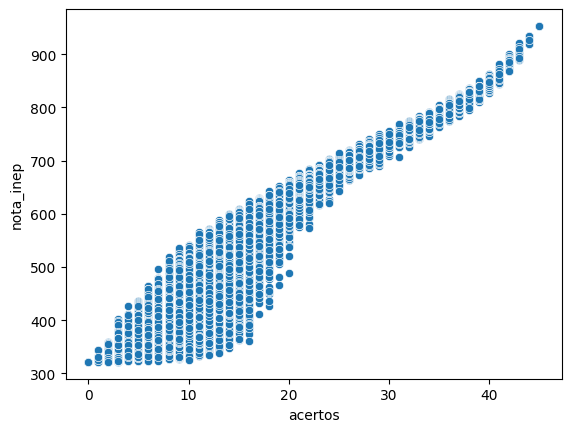

In [36]:
from util import load_acertos
ac = load_acertos(2011,'MT',perc=2)
sns.scatterplot(ac,x='acertos',y='nota_inep')

Mas tem algo errado com 2011 / CH, e talvez outros.. Teremos que investigar

<Axes: xlabel='acertos', ylabel='nota_inep'>

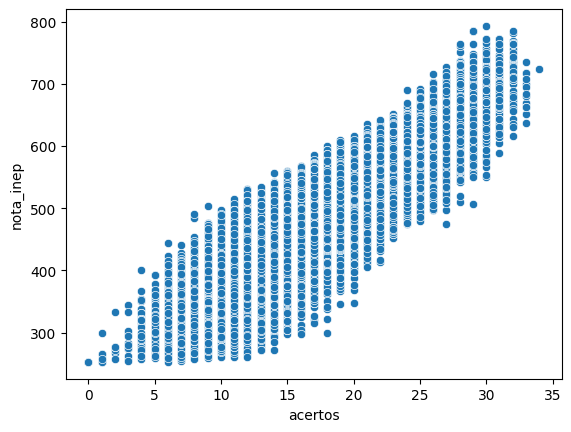

In [41]:
ac = load_acertos(2011,'CH',perc=2)
sns.scatterplot(ac,x='acertos',y='nota_inep')

# Calcular estatísticas TCT dos itens
Usamos a função `mirt::itemstats`. A função item_stats em util.py usa o arquivo itens_inep.csv gerado acima e depende também dos arquivos dos acertos gerados acima.

Também inserimos um URL para as resoluções comentados do Objetivo. Cuidado: não checei exaustivamente todos as gambiaras para chegar no URL certo. No notebook Análise de Itens exemplos de como usar as planilhas geradas pela célula abaixo.

In [46]:
from util import item_stats
istats = item_stats(2011,'CH',perc=2)
istats

,N,mean,sd,total.r,total.r_if_rm,alpha_if_rm,url,CO_POSICAO,SG_AREA,TX_GABARITO,...,TX_MOTIVO_ABAN,NU_PARAM_A,NU_PARAM_B,NU_PARAM_C,TX_COR,CO_PROVA,ano,TP_LINGUA,IN_ITEM_ADAPTADO,TP_VERSAO_DIGITAL
75504,65403,0.799658,0.400260,0.423483,0.354294,0.634339,https://www.curso-objetivo.br/vestibular/resol...,3,CH,E,...,NaN,3.21898,-0.50056,0.36109,ROSA,120,2011,NaN,NaN,NaN
73764,65403,0.448450,0.497339,0.168457,0.069553,0.653102,https://www.curso-objetivo.br/vestibular/resol...,2,CH,D,...,NaN,0.34715,0.36053,0.02354,AZUL,117,2011,NaN,NaN,NaN
71745,65403,0.522912,0.499479,0.393639,0.304131,0.635242,https://www.curso-objetivo.br/vestibular/resol...,3,CH,E,...,NaN,1.98100,0.29799,0.14845,AZUL,117,2011,NaN,NaN,NaN
75632,65403,0.246365,0.430897,0.357058,0.278303,0.638449,https://www.curso-objetivo.br/vestibular/resol...,4,CH,B,...,NaN,2.54487,0.97652,0.12278,BRANCO,119,2011,NaN,NaN,NaN
73690,65403,0.176934,0.381616,0.211803,0.137111,0.647698,https://www.curso-objetivo.br/vestibular/resol...,4,CH,C,...,NaN,2.93542,1.37299,0.13042,ROSA,120,2011,NaN,NaN,NaN
73785,65403,0.244408,0.429739,0.232554,0.148829,0.646993,https://www.curso-objetivo.br/vestibular/resol...,5,CH,E,...,NaN,2.53827,1.11917,0.18589,ROSA,120,2011,NaN,NaN,NaN
75451,65403,0.271639,0.444808,0.239018,0.152489,0.646764,https://www.curso-objetivo.br/vestibular/resol...,9,CH,A,...,NaN,1.14241,1.84779,0.17173,ROSA,120,2011,NaN,NaN,NaN
71139,65403,0.645735,0.478294,0.320404,0.230598,0.641122,https://www.curso-objetivo.br/vestibular/resol...,13,CH,E,...,NaN,1.79484,0.39595,0.44445,ROSA,120,2011,NaN,NaN,NaN
73555,65403,0.468190,0.498991,0.344901,0.252400,0.639266,https://www.curso-objetivo.br/vestibular/resol...,13,CH,D,...,NaN,1.17341,0.49445,0.17226,BRANCO,119,2011,NaN,NaN,NaN
75438,65403,0.901793,0.297596,0.274738,0.218275,0.644246,https://www.curso-objetivo.br/vestibular/resol...,8,CH,B,...,NaN,1.27649,-2.10568,0.03530,ROSA,120,2011,NaN,NaN,NaN


In [ ]:
for ano in range(2009,2024):
    for area in ['MT','CH','CN','LC','LC_esp','LC_en']:
        if ano == 2009 and area in ['LC_esp','LC_en']: 
            continue
        istats = item_stats(ano,area,perc=2)
        istats.to_csv(f'data/istats-{ano}-{area}.csv',index_label='item')

# Calcular notas e parâmetros da escala ENEM

## XXX esta parte refiz na planilha 01-Notas
Talvez no futuro levamos os análises no notebook 01-Notas para cá.

Podemos transformar as padrões de resposta para uma nota de duas formas: usando a função `mirt::fscore` e nossa própria função . Para transformar as notas que estão distribuídas aproximademente $N(0,1)$ para a "Escala ENEM" (que é aproximadamente $N(500,100)$), precisamos dos parâmetros de conversão, que vamos calcular agora. 

In [18]:
from util import provas,load_padr,score_inep
import scipy

Ano 2009 e prova = 50
Ano 2009 e prova = 51
Ano 2009 e prova = 49
Ano 2009 e prova = 52
Ano 2010 e prova = 92
Ano 2010 e prova = 90
Ano 2010 e prova = 89
Ano 2010 e prova = 91
Ano 2011 e prova = 121
skipping prova 121, to be investigated
Ano 2011 e prova = 124
skipping prova 124, to be investigated
Ano 2011 e prova = 122
skipping prova 122, to be investigated
Ano 2011 e prova = 123
skipping prova 123, to be investigated
Ano 2012 e prova = 143
Ano 2012 e prova = 144
Ano 2012 e prova = 141
Ano 2012 e prova = 142
Ano 2013 e prova = 174
Ano 2013 e prova = 171
Ano 2013 e prova = 172
Ano 2013 e prova = 173
Ano 2014 e prova = 199
Ano 2014 e prova = 201
Ano 2014 e prova = 200
Ano 2014 e prova = 202
Ano 2015 e prova = 235
Ano 2015 e prova = 236
Ano 2015 e prova = 237
Ano 2015 e prova = 238
Ano 2016 e prova = 291
Ano 2016 e prova = 292
Ano 2016 e prova = 293
Ano 2016 e prova = 294
Ano 2017 e prova = 392
Standard error of the regression > 0.01 for ano 2017, area CN and prova 392
slope = 125.51177

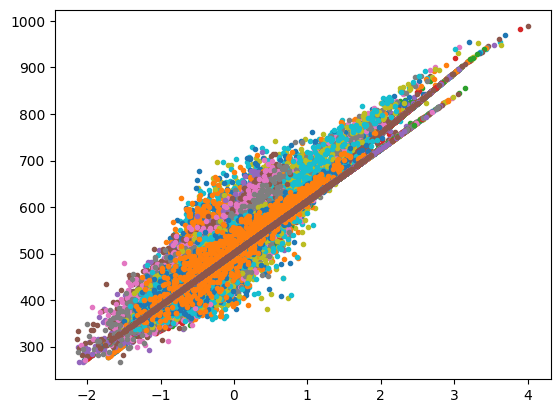

In [44]:
# vamos ter que pular o ano 2011 para a área CN, porque existe um item que não foi marcado como abandonado, 
# mas para qual o INEP não deu os parâmetros IRT
# TODO: investigar se o item foi abandonado (conseguimos reproduzir as notas do INEP sem este item) 
# OU se o item foi usado, mas não sabemos os parâmetros. 
# Estamos com dificuldades de reproduzir exatamente as notas de 2017 e 2018 também. 
# TODO: investigar as razões das discrepâncias para os anos que não conseguimos reproduzir
# TODO: fazer a calibragem para a área LC
results = pd.DataFrame(columns=['ano','area','prova','slope','intercept','stderr'])
for area in ['CN','MT','CH']:
    for ano in range(2009,2024):
        provs = provas(ano,area)
        for prova in provs:
            print(f"Ano {ano} e prova = {prova}")
            padr,notas_inep= load_padr(prova,1000,nota_inep=True)
            if prova in [122,121,123,124]:
                print(f"skipping prova {prova}, to be investigated")
                continue
            notas = score_inep(padr,prova)
            
            x = notas['nota']
            y = notas_inep['nota_inep']
            plt.plot(x,y,'.')
            res = scipy.stats.linregress(x, y)
            if res.stderr > 0.01:
                print(f"Standard error of the regression > 0.01 for ano {ano}, area {area} and prova {prova}")
                print(f"slope = {res.slope}, intercept = {res.intercept}, stderr = {res.stderr}")
            results.loc[len(results)] = [ano,area,prova,res.slope,res.intercept,res.stderr]
    
results['prova'] = results['prova'].astype('int')
results['ano'] = results['ano'].astype('int')    
results.to_csv(f'data/scorecal.csv',index=False)

Uma vez calibrado, podemos agora converter notas e parâmetros dos itens para a escala ENEM